# EigenFaces

## Step 1: Preprocessing the Images

### Load the images

In [2]:
import bz2
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

directory = 'feret/'
faces = {}

for index, person_id in enumerate(os.listdir(directory)):
    if index > 20:
        break

    person_path = os.path.join(directory, person_id)
    
    if os.path.isdir(person_path):
        for image_id in os.listdir(person_path):
            image_path = os.path.join(person_path, image_id)

            if image_path.endswith(".ppm.bz2"):
                with bz2.BZ2File(image_path, 'rb') as f:
                    content = f.read()
                image = cv2.imdecode(np.frombuffer(content, np.uint8), cv2.IMREAD_GRAYSCALE)

                file_path = "/".join(image_path.split("/")[1:])
                faces[file_path] = image

### Let's see some of them

Showing sample faces


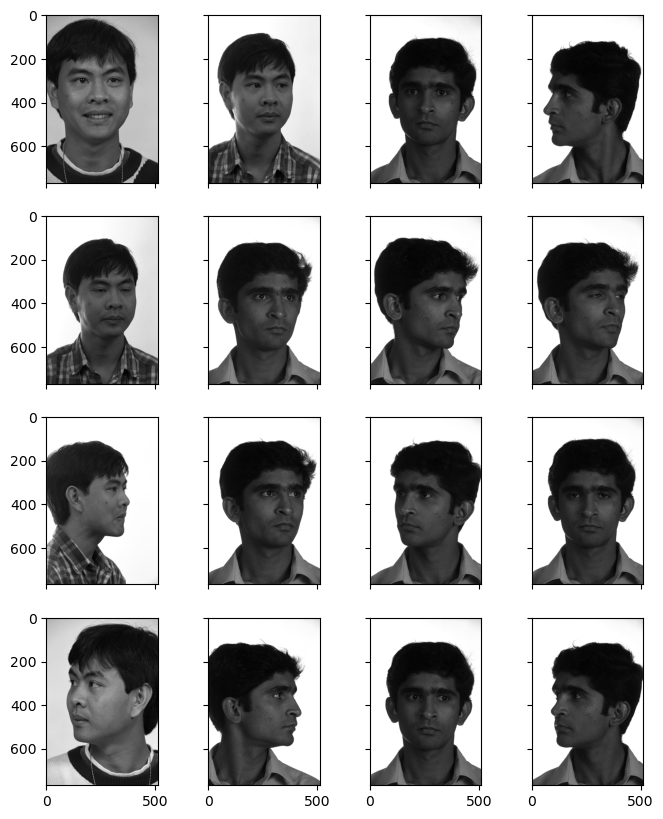

In [2]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("Showing sample faces")
plt.show()

### Some details about the data

In [3]:
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of images:", len(faces))

Face image shape: (768, 512)
Number of classes: 21
Number of images: 239


### Split the data into training and test data

In [4]:
from sklearn.model_selection import train_test_split

facematrix = []
facelabel = []
for key,val in faces.items():
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

facematrix = np.array(facematrix)
facelabel = np.array(facelabel)

Xtr, Xts, ytr, yts = train_test_split(facematrix, facelabel, test_size=0.25, stratify = facelabel)

# Step 2: Training

### Apply PCA and take first K principal components as eigenfaces

In [5]:
from sklearn.decomposition import PCA

pca = PCA().fit(Xtr)

n_components = 100
eigenfaces = pca.components_[:n_components]

### Let's see some of the eigenfaces

Showing the eigenfaces


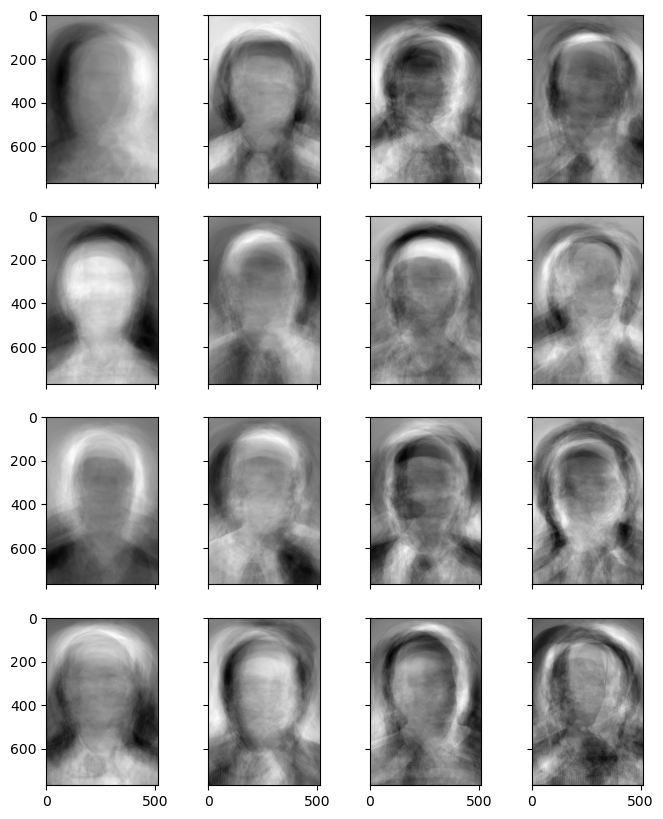

In [6]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
print("Showing the eigenfaces")
plt.show()

### Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples

In [7]:
weights = eigenfaces @ (Xtr - pca.mean_).T
print("Shape of the weight matrix:", weights.shape)

Shape of the weight matrix: (100, 179)


### Compute the threshold

In [8]:
distances = []

for i in range(len(Xts)):
    test_image = Xts[i].reshape(1, -1)
    test_weight = eigenfaces @ (test_image - pca.mean_).T
    euclidean_distance = np.linalg.norm(weights - test_weight, axis=0)
    best_match = np.argmin(euclidean_distance)


    if yts[i] == ytr[best_match]:
        distances.append(euclidean_distance[best_match])


threshold = max(distances)
print("Optimum Threshold: ", threshold)

Optimum Threshold:  30545.823116528692


# Step 3: Test

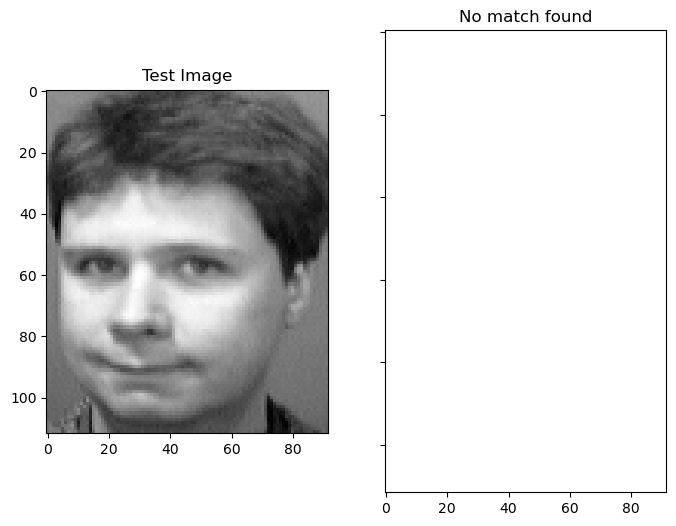

In [20]:
# with bz2.BZ2File("feret/00018/00018_930831_fa.ppm.bz2", 'rb') as f:
#     content = f.read()
# test_image = cv2.imdecode(np.frombuffer(content, np.uint8), cv2.IMREAD_GRAYSCALE).reshape(1, -1)
num = 45
test_image = Xts[num].reshape(1, -1)

test_weight = eigenfaces @ (test_image - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - test_weight, axis=0)
best_match = np.argmin(euclidean_distance)


reconstructed_face = pca.mean_ + (test_weight.T @ eigenfaces)
reconstruction_error = np.linalg.norm(test_image - reconstructed_face)


fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(test_image.reshape(faceshape), cmap="gray")
axes[0].set_title(f"Test Image")


if reconstruction_error > threshold:
    print("not a face")
    axes[1].set_title(f"Not Available")

elif euclidean_distance[best_match] > threshold:
    axes[1].set_title(f"No match found")

else:
    print("Match found! Person: %s with Euclidean distance %f" % (ytr[best_match], euclidean_distance[best_match]))
    axes[1].imshow(Xtr[best_match].reshape(faceshape), cmap="gray")
    axes[1].set_title(f"Best match - {ytr[best_match]}")

plt.show()